In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization
from scipy.stats import zscore


plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=10**5),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=10**5)}

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [3]:
w_gen = zscore(datasets['Pythia26']['gen_widths']) #gen = particle level
w_sim = zscore(datasets['Pythia26']['sim_widths']) #sim = detector level
w_truth = zscore(datasets['Herwig']['gen_widths'])
w_data = zscore(datasets['Herwig']['sim_widths'])

p_gen = zscore(datasets['Pythia26']['gen_jets'][:,0]) #gen = particle level
p_sim = zscore(datasets['Pythia26']['sim_jets'][:,0]) #sim = detector level
p_truth = zscore(datasets['Herwig']['gen_jets'][:,0])
p_data = zscore(datasets['Herwig']['sim_jets'][:,0])

In [4]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.m0 = self.add_weight(name='m0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.m1 = self.add_weight(name='m1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v0 = self.add_weight(name='v0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self.v1 = self.add_weight(name='v1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        y = tf.exp((self.m0 + self.m1*x[:, 0]) * x[:,1] + (self.v0 + self.v1*x[:,0]) * x[:,1]**2)
        return tf.reshape(y, (len(x), 1))

In [5]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [39]:
myc = 4


mymodel_inputtest = Input(shape=(2,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((2, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')
    
model_discrimantor.trainable = False
mymodel_gan = Input(shape=(2,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')

In [40]:
xvals_particle = np.transpose([np.concatenate([w_gen,w_truth]), np.concatenate([p_gen,p_truth])])
xvals_detector = np.transpose([np.concatenate([w_sim,w_data]), np.concatenate([p_sim,p_data])])                        
yvals = np.transpose(np.concatenate([np.ones(len(w_gen)),np.zeros(len(w_truth))]))

X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test = train_test_split(xvals_particle, 
                                                                                                        xvals_detector,
                                                                                                        yvals)

In [8]:
n_epochs = 20
n_batch = 128*10
n_batches = len(X_train_particle) // n_batch

for i in range(n_epochs):
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        X_batch_particle = X_train_particle[j*n_batch:(j+1)*n_batch]
        X_batch_detector = X_train_detector[j*n_batch:(j+1)*n_batch]
        Y_batch = Y_train[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch_particle)
        W_batch = np.array(W_batch).flatten()
        
        W_batch[Y_batch==1] = 1        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimantor.train_on_batch(X_batch_detector, Y_batch_2)        
        gan_model.train_on_batch(X_batch_particle[Y_batch==0],np.zeros(len(X_batch_particle[Y_batch==0])))
    mylambda = np.array(model_generator.layers[-1].get_weights())
    print("on epoch=", i, mylambda.T)

on epoch= 0 [[ 0.00895447  0.001396   -0.01105283 -0.01642079]]
on epoch= 1 [[ 0.02512443 -0.01871743 -0.01302688 -0.00522834]]
on epoch= 2 [[ 0.04193172 -0.03422225 -0.01427146  0.00119852]]
on epoch= 3 [[ 0.0082936   0.00617529 -0.00528268 -0.01155422]]
on epoch= 4 [[ 0.02347127 -0.0109203  -0.00890194 -0.01051139]]
on epoch= 5 [[ 0.02249421 -0.01125699 -0.01539936 -0.01525855]]
on epoch= 6 [[ 0.02723903 -0.01406117 -0.01375683 -0.01253365]]
on epoch= 7 [[ 0.02010226 -0.01383447 -0.00996756 -0.01433323]]
on epoch= 8 [[ 0.02335788 -0.01449541 -0.00425791 -0.01260367]]
on epoch= 9 [[ 0.03479359 -0.01529496 -0.01002331 -0.01124184]]
on epoch= 10 [[ 0.024363   -0.01667407 -0.00989625 -0.01259966]]
on epoch= 11 [[ 0.0149307  -0.0093843  -0.00765803 -0.01360196]]
on epoch= 12 [[-0.00641709 -0.01486334 -0.00337834 -0.01221153]]
on epoch= 13 [[ 0.0265342  -0.01945783 -0.02072595 -0.01999676]]
on epoch= 14 [[ 0.03167117 -0.01565508 -0.01196562 -0.01812368]]
on epoch= 15 [[ 0.02342395 -0.01694

In [35]:
arr = np.exp(np.array((mylambda[0] + mylambda[1]*p_gen) * w_gen + (mylambda[2] + mylambda[3]*p_gen) * w_gen**2))
weights = np.concatenate([arr*len(w_gen)/np.sum(arr), np.ones(len(w_gen))])
X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test, w_train, w_test = train_test_split(xvals_particle, 
                                                                                                        xvals_detector,
                                                                                                        yvals, weights)

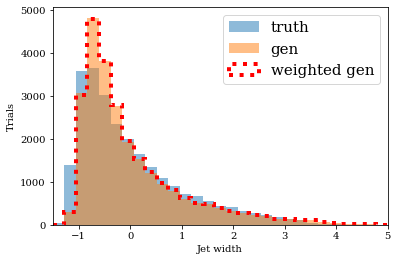

In [37]:
nbins = 30
min = -1.5
max = 5
_,_,_=plt.hist(X_test_particle[Y_test==0][:,0],bins=np.linspace(min,max,nbins),alpha=0.5,label="truth")
_,_,_=plt.hist(X_test_particle[Y_test==1][:,0],bins=np.linspace(min, max,nbins),alpha=0.5,label="gen")
_,_,_=plt.hist(X_test_particle[Y_test==1][:,0],bins=np.linspace(min,max,nbins),weights=w_test[Y_test==1],histtype="step",color="r",ls=":", lw=4,label="weighted gen")
plt.legend(fontsize=15)
plt.xlabel("Jet width")
plt.ylabel("Trials")
plt.xlim(min, max)
plt.savefig("jetexample.pdf", bbox_inches='tight', transparent=True)